In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
import numpy as np
import pandas as pd
import collections

In [2]:
x_name = os.path.join(os.getcwd(), '데이터SET', f"{'[Track1_데이터3] samp_cst_feat'}.csv")
df_x = pd.read_csv(x_name, index_col=0)

y_name = os.path.join(os.getcwd(), '데이터SET', f"{'[Track1_데이터2] samp_train'}.csv")
df_y = pd.read_csv(y_name, index_col=0)

df = pd.merge(df_x, df_y, on='cst_id_di')

In [3]:
df.MRC_ID_DI[df.MRC_ID_DI > 0 ] = 1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [4]:
nc_name = os.path.join(os.getcwd(), '데이터SET', f"{'[Track1_데이터4] variable_dtype'}.xlsx")
nc = pd.read_excel(nc_name, index_col=0)

In [5]:
"""
from  sklearn.preprocessing import scale
from statsmodels.nonparametric.kde import KDEUnivariate

def find_outliers_kde(x):
    x_scaled = scale(list(map(float, x)))
    kde = KDEUnivariate(x_scaled)
    kde.fit(bw='scott', fft=True)
    pred = kde.evaluate(x_scaled)
    
    n = sum(pred < 0.01)
    outlier_ind = np.asarray(pred).argsort()[:n]
    outlier_value = np.asarray(x)[outlier_ind]
    
    return outlier_ind, outlier_value

for i in df.columns[0:-1]:
    if nc.loc[i, 'dType'] == 'numerical':
        kde_indices, kde_values = find_outliers_kde(df[i])
        df_50 = df[i].quantile(0.50)
        for j in range(len(df)):
            if df[i].values[j] in kde_values:
                df.at[j, i] = df_50
"""
for i in df.columns[0:-1]:
    if nc.loc[i, 'dType'] == 'numerical':
        d_90 = df[i].quantile(0.99)
        d_10 = df[i].quantile(0.01)
        d_50 = df[i].quantile(0.50)
        df[i] = np.where(df[i] > d_90, d_90, df[i])
        df[i] = np.where(df[i] < d_10, d_10, df[i])
print(df.shape)

(10124, 227)


In [7]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [8]:
import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                      exception_only=False, running_compiled_code=False):
       etype, value, tb = sys.exc_info()
       return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

In [289]:
df_0 = df[df['MRC_ID_DI'] == 0].sample(frac=1)
df_1 = df[df['MRC_ID_DI'] == 1].sample(frac=1)

sample_size = len(df_0) if len(df_0) < len(df_1) else len(df_1)

df_h = pd.concat([df_0.head(sample_size), df_1.head(sample_size)]).sample(frac=1)
df_t = pd.concat([df_0.tail(sample_size), df_1.head(sample_size)]).sample(frac=1)
df_f = pd.concat([df_h, df_t]).sample(frac=1)

In [290]:
X = df_f.drop(columns = ['MRC_ID_DI'], axis=1)
#y = tf.keras.utils.to_categorical(df_f['MRC_ID_DI'])
y = df_f['MRC_ID_DI']

In [291]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [292]:
num, cat = list(), list()
for i in X.columns:
    if nc.loc[i, 'dType'] == 'numerical':
        num.append(i)
    else:
        cat.append(i)


X1_train = X_train[num]
X1_test = X_test[num]

X2_train = X_train[cat]
X2_test = X_test[cat]

In [293]:
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures

def add_interactions(df1, df2):
    df = pd.concat([df1, df2])
    combos = list(combinations(list(df.columns), 2))
    colnames = list(df.columns) + ['_'.join(x) for x in combos]
    
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    df = poly.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames
    
    noint_indicies = [i for i, x in enumerate(list((df == 0).all())) if x]
    df = df.drop(df.columns[noint_indicies], axis = 1)
    return df[:len(df1)], df[len(df1):]

X1_train, X1_test = add_interactions(X1_train, X1_test)
X2_train, X2_test = add_interactions(X2_train, X2_test)

In [294]:
import sklearn.feature_selection

select = sklearn.feature_selection.SelectKBest(k=len(X1_train.columns)//2)
selected_features = select.fit(X1_train, y_train)
indices_selected = selected_features.get_support(indices=True)
colnames_selected = [X1_train.columns[i] for i in indices_selected]

X1_train = X1_train[colnames_selected]
X1_test = X1_test[colnames_selected]

select = sklearn.feature_selection.SelectKBest(k=len(X2_train.columns)//2)
selected_features = select.fit(X2_train, y_train)
indices_selected = selected_features.get_support(indices=True)
colnames_selected = [X2_train.columns[i] for i in indices_selected]

X2_train = X2_train[colnames_selected]
X2_test = X2_test[colnames_selected]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [83] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [295]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [296]:
input_1 = tf.keras.Input(dtype = tf.float32, shape = (len(X1_train.columns),))
input_2 = tf.keras.Input(dtype = tf.float32, shape = (len(X2_train.columns),))

dense_layer_1_1 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(input_1)
dense_layer_1_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_1)
dense_layer_1_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_2)
dense_layer_1_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_3)
dropout_1_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_1_1)


dense_layer_2_1 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(input_2)
dense_layer_2_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_1)
dense_layer_2_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_2)
dense_layer_2_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_3)
dropout_2_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_2_1)

concat_layer = tf.keras.layers.Concatenate()([dropout_1_5, dropout_2_5])


dense_layer_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(concat_layer)
dense_layer_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_3)
dense_layer_5 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4)
dense_layer_6 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_5)

output = tf.keras.layers.Dense(units = 2, activation = tf.nn.softmax)(dense_layer_3)

In [297]:
model = tf.keras.Model(inputs=[input_1, input_2], outputs=output)

In [298]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=0.00005), metrics=['acc'])
print(model.summary())

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 9850)]       0                                            
__________________________________________________________________________________________________
input_42 (InputLayer)           [(None, 167)]        0                                            
__________________________________________________________________________________________________
dense_260 (Dense)               (None, 10)           98510       input_41[0][0]                   
__________________________________________________________________________________________________
dense_264 (Dense)               (None, 10)           1680        input_42[0][0]                   
___________________________________________________________________________________________

In [299]:
#history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=400, verbose=1, validation_split=0.1)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
history = model.fit(x=[X1_train, X2_train], y=y_train, batch_size=32, epochs=2000, verbose=1, validation_split=0.1, callbacks=[callback])

Train on 6233 samples, validate on 693 samples
Epoch 1/2000
6233/6233 [==============================] - 1s 142us/sample - loss: 0.5808 - acc: 0.7003 - val_loss: 0.5120 - val_acc: 0.7504
Epoch 2/2000
6233/6233 [==============================] - 1s 98us/sample - loss: 0.5207 - acc: 0.7451 - val_loss: 0.4951 - val_acc: 0.7489
Epoch 3/2000
6233/6233 [==============================] - 1s 89us/sample - loss: 0.5046 - acc: 0.7555 - val_loss: 0.4836 - val_acc: 0.7590
Epoch 4/2000
6233/6233 [==============================] - 1s 90us/sample - loss: 0.4895 - acc: 0.7658 - val_loss: 0.4739 - val_acc: 0.7706
Epoch 5/2000
6233/6233 [==============================] - 1s 90us/sample - loss: 0.4830 - acc: 0.7714 - val_loss: 0.4742 - val_acc: 0.7706
Epoch 6/2000
6233/6233 [==============================] - 1s 88us/sample - loss: 0.4763 - acc: 0.7767 - val_loss: 0.4665 - val_acc: 0.7792
Epoch 7/2000
6233/6233 [==============================] - 1s 87us/sample - loss: 0.4683 - acc: 0.7781 - val_loss: 0.46

6233/6233 [==============================] - 1s 92us/sample - loss: 0.3556 - acc: 0.8447 - val_loss: 0.4079 - val_acc: 0.8153
Epoch 60/2000
6233/6233 [==============================] - 1s 98us/sample - loss: 0.3529 - acc: 0.8497 - val_loss: 0.4096 - val_acc: 0.8124
Epoch 61/2000
6233/6233 [==============================] - 1s 95us/sample - loss: 0.3537 - acc: 0.8498 - val_loss: 0.4108 - val_acc: 0.8110
Epoch 62/2000
6233/6233 [==============================] - 1s 97us/sample - loss: 0.3542 - acc: 0.8519 - val_loss: 0.4080 - val_acc: 0.8196
Epoch 63/2000
6233/6233 [==============================] - 1s 94us/sample - loss: 0.3508 - acc: 0.8542 - val_loss: 0.4069 - val_acc: 0.8196
Epoch 64/2000
6233/6233 [==============================] - 1s 104us/sample - loss: 0.3454 - acc: 0.8540 - val_loss: 0.4059 - val_acc: 0.8182
Epoch 65/2000
6233/6233 [==============================] - 1s 99us/sample - loss: 0.3469 - acc: 0.8530 - val_loss: 0.4047 - val_acc: 0.8211
Epoch 66/2000
6233/6233 [========

6233/6233 [==============================] - 1s 99us/sample - loss: 0.2678 - acc: 0.8895 - val_loss: 0.3891 - val_acc: 0.8326
Epoch 118/2000
6233/6233 [==============================] - 1s 98us/sample - loss: 0.2695 - acc: 0.8911 - val_loss: 0.3897 - val_acc: 0.8240
Epoch 119/2000
6233/6233 [==============================] - 1s 102us/sample - loss: 0.2708 - acc: 0.8922 - val_loss: 0.3865 - val_acc: 0.8312
Epoch 120/2000
6233/6233 [==============================] - 1s 99us/sample - loss: 0.2670 - acc: 0.8960 - val_loss: 0.3863 - val_acc: 0.8312
Epoch 121/2000
6233/6233 [==============================] - 1s 102us/sample - loss: 0.2610 - acc: 0.8978 - val_loss: 0.3902 - val_acc: 0.8283
Epoch 122/2000
6233/6233 [==============================] - 1s 105us/sample - loss: 0.2623 - acc: 0.8984 - val_loss: 0.3882 - val_acc: 0.8312
Epoch 123/2000
6233/6233 [==============================] - 1s 125us/sample - loss: 0.2576 - acc: 0.8968 - val_loss: 0.3875 - val_acc: 0.8384
Epoch 124/2000
6233/6233

6233/6233 [==============================] - 1s 104us/sample - loss: 0.1919 - acc: 0.9284 - val_loss: 0.3877 - val_acc: 0.8398
Epoch 176/2000
6233/6233 [==============================] - 1s 95us/sample - loss: 0.1881 - acc: 0.9339 - val_loss: 0.3840 - val_acc: 0.8398
Epoch 177/2000
6233/6233 [==============================] - 1s 95us/sample - loss: 0.1905 - acc: 0.9321 - val_loss: 0.3804 - val_acc: 0.8442
Epoch 178/2000
6233/6233 [==============================] - 1s 100us/sample - loss: 0.1918 - acc: 0.9305 - val_loss: 0.3862 - val_acc: 0.8485
Epoch 179/2000
6233/6233 [==============================] - 1s 100us/sample - loss: 0.1863 - acc: 0.9341 - val_loss: 0.3805 - val_acc: 0.8427
Epoch 180/2000
6233/6233 [==============================] - 1s 99us/sample - loss: 0.1857 - acc: 0.9360 - val_loss: 0.3837 - val_acc: 0.8470
Epoch 181/2000
6233/6233 [==============================] - 1s 98us/sample - loss: 0.1861 - acc: 0.9318 - val_loss: 0.3852 - val_acc: 0.8499
Epoch 182/2000
6233/6233 

Epoch 233/2000
6233/6233 [==============================] - 1s 95us/sample - loss: 0.1237 - acc: 0.9556 - val_loss: 0.3836 - val_acc: 0.8586
Epoch 234/2000
6233/6233 [==============================] - 1s 95us/sample - loss: 0.1272 - acc: 0.9549 - val_loss: 0.4100 - val_acc: 0.8514
Epoch 235/2000
6233/6233 [==============================] - 1s 95us/sample - loss: 0.1300 - acc: 0.9532 - val_loss: 0.3930 - val_acc: 0.8615
Epoch 236/2000
6233/6233 [==============================] - 1s 94us/sample - loss: 0.1254 - acc: 0.9560 - val_loss: 0.4051 - val_acc: 0.8528
Epoch 237/2000
6233/6233 [==============================] - 1s 94us/sample - loss: 0.1234 - acc: 0.9592 - val_loss: 0.3924 - val_acc: 0.8586
Epoch 238/2000
6233/6233 [==============================] - 1s 94us/sample - loss: 0.1238 - acc: 0.9570 - val_loss: 0.4041 - val_acc: 0.8586
Epoch 239/2000
6233/6233 [==============================] - 1s 95us/sample - loss: 0.1239 - acc: 0.9583 - val_loss: 0.4016 - val_acc: 0.8600
Epoch 240/200

Epoch 291/2000
6233/6233 [==============================] - 1s 99us/sample - loss: 0.0866 - acc: 0.9706 - val_loss: 0.4872 - val_acc: 0.8557
Epoch 292/2000
6233/6233 [==============================] - 1s 96us/sample - loss: 0.0886 - acc: 0.9668 - val_loss: 0.4145 - val_acc: 0.8716
Epoch 293/2000
6233/6233 [==============================] - 1s 100us/sample - loss: 0.0878 - acc: 0.9695 - val_loss: 0.4421 - val_acc: 0.8644
Epoch 294/2000
6233/6233 [==============================] - 1s 100us/sample - loss: 0.0839 - acc: 0.9710 - val_loss: 0.4687 - val_acc: 0.8629
Epoch 295/2000
6233/6233 [==============================] - 1s 98us/sample - loss: 0.0834 - acc: 0.9676 - val_loss: 0.4351 - val_acc: 0.8672
Epoch 296/2000
6233/6233 [==============================] - 1s 98us/sample - loss: 0.0810 - acc: 0.9727 - val_loss: 0.4526 - val_acc: 0.8571
Epoch 297/2000
6233/6233 [==============================] - 1s 97us/sample - loss: 0.0805 - acc: 0.9711 - val_loss: 0.4552 - val_acc: 0.8615
Epoch 298/2

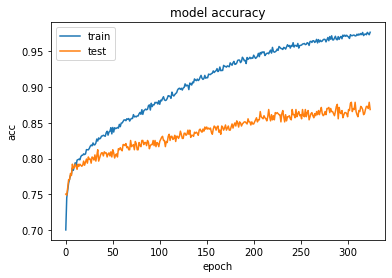

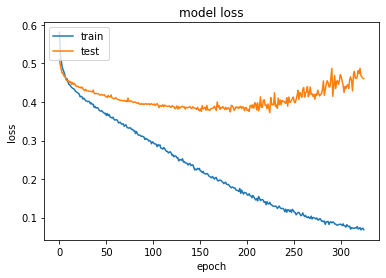

In [300]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [301]:
score = model.evaluate(x=[X1_test, X2_test], y=y_test, verbose=1)

print("Test Score:", score[0])
print("Test ACC:", score[1])

770/770 [==============================] - 0s 100us/sample - loss: 0.4854 - acc: 0.8766
Test Score: 0.48543440815689864
Test ACC: 0.8766234
